In [1]:
import sys
import numpy as np
import torch
import math
%matplotlib inline
import matplotlib.pyplot as plt

torch.manual_seed(1) # Fix seed of the random number generators
np.random.seed(1)

The function below is used to plot mnist images

In [2]:
def show_imgs(imgs,l1=4,l2=5,s1=6,s2=6):
    """    Plot images    """
    plt.rcParams['figure.figsize']=(s1,s2)
    imgs=imgs.reshape([-1,28,28])
    g, ax = plt.subplots(l1,l2)
    for i in range(l1):
        for j in range(l2):
            a=i*l1+j
            if(a>=imgs.shape[0]):
                break
            ax[i][j].imshow(imgs[a,:,:],cmap='summer')
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
    plt.show()

### Data loading
$100$ MNIST images have been stored as "mnist_100_28x28_p0.5.npy".  
Each image contains $n=28\times 28=784$ pixels, each of which takes value $0$ or $1$.  
In our settings, each image is viewed as a product state in the Hilbert space of  dimension $2^n$.

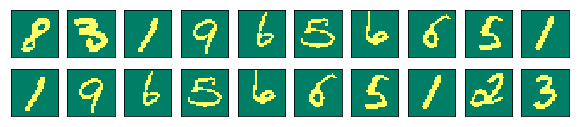

In [3]:
n=784 # number of qubits
m=20 # m images
data=np.load("mnist_100_28x28_p0.5.npy")
data=data[:m,:,:]
data=torch.LongTensor(data)
data=data.view(-1,784) # m images, each of which is reshaped into a vector of length 784
show_imgs(data,2,10,10,2)

### MPS initialization
Define the mps, which is a list of 3-way tensors containing random values

In [4]:
Dmax=30 # maximum bond dimension
bond_dims=[Dmax for i in range(n-1)]+[1]
tensors= [ torch.randn(bond_dims[i-1],2,bond_dims[i]) for i in range(n)]

Now check the bond dimensions and tensors

In [5]:
print("There are len(tensors) tensors")
print(bond_dims)
print(tensors[5].shape)

There are len(tensors) tensors
[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 

Question: does the contration with one image give a probability of the image? Why?

Canonicalization using QR decompositions

In [6]:
def orthogonalize(site,going_right):
    dl=bond_dims[site-1] # left bond dimension
    d=bond_dims[site]   # current bond dimension
    if(going_right):
        #print("site=",site,tensors[site].shape,"dl=",dl,"d=",d)
        A=tensors[site].view(dl*2,d) # A is a matrix unfolded from the current tensor
        Q,R=torch.qr(A)
        R/=R.norm() # devided by norm 
        tensors[site] = Q.contiguous().view(dl,2,-1)
        tensors[site+1] = (R@tensors[site+1].view(d,-1)).view(-1,2,bond_dims[site+1])
        bond_dims[site] = Q.shape[1] # economy QR, so the right dimension could be either dl or d
    else: # going left
        A=tensors[site].view(dl,d*2).t()
        Q,R=torch.qr(A)
        R/=R.norm() 
        tensors[site]=Q.t().contiguous().view(-1,2,d)
        tensors[site-1] = (tensors[site-1].view(-1,dl)@R.t()).view(bond_dims[site-2],2,-1)
        bond_dims[site-1] = Q.shape[1]


### MPS left canonicalization
Canonicalization gives several advantages. 

First, it make the partition function of the model equals to $1$. 

Second, the isometries have condition number $1$, preserving very well the computation precisions.

In [7]:
for site in range(n-1):
    orthogonalize(site,True)     

In [8]:
tensors[783].shape

torch.Size([30, 2, 1])

Canonicalization changes the bond dimensions, to see it

In [9]:
print(bond_dims)

[2, 4, 8, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30

Now contracting mps with one image gives the probability amplitude of the image.

In [10]:
def get_psi():
    psi=torch.ones([m,1,1])
    for site in range(n):
        psi = psi @ tensors[site][:,data[:,site],:].permute(1,0,2)
    return(psi)

In [11]:
def gen_samples(ns):
    samples=np.zeros([ns,n])
    for site in range(n-1):# left canonicalize
        orthogonalize(site,True) 
    for s in range(ns):
        vec=torch.ones(1,1)
        for site in range(n-1,-1,-1):
            vec = (tensors[site].view(-1,bond_dims[site])@vec).view(-1,2)
            p0 = vec[:,0].norm()**2/ (vec.norm()**2)
            x = (0 if np.random.rand() < p0 else 1)
            vec = vec[:,x]
            samples[s][site]=x
    return samples

### Initialize cache for MPS
Computing probability of a image consists of contracting bonds from the first tensor to the last tensor. Lots of computation results can be re-used in the future computations, so we would like to store the contraction results in the cache.
Notice that the cache is for all images.

In [12]:
cache=[] 
cache.append( torch.ones([m,1,1])) # The initial elements, all images have cache 1
for site in range(n-1):
    B=cache[site] @ tensors[site][:,data[:,site],:].permute(1,0,2)
    B /= B.abs().max()
    cache.append(  B  ) # batched matrix multiplications
cache.append( torch.ones(m,1,1)) # the last element, matrix [1,1] for all images

Length of the case is $n+1$. In the caceh, for an image, each pixel has a correponding vector, denoting the temporary results in tensor contractions (from left to right or from right to left).
Let us look at the content of cache for image alpha=1:

In [13]:
alpha=1 # the image 1
print("cache site 1 ",cache[0][alpha])
print("cache site 2 ",cache[1][alpha])
print("cache site 3 ",cache[2][alpha])
print("cache site 4 ",cache[3][alpha])
print("cache site 5 ",cache[4][alpha])
print("cache site 6 ",cache[4][alpha])

cache site 1  tensor([[ 1.]])
cache site 2  tensor([[-1.0000, -0.5231]])
cache site 3  tensor([[ 0.6791,  0.3302, -0.6933,  1.0000]])
cache site 4  tensor([[-0.6459,  0.2046, -1.0000, -0.5822, -0.5152,  0.2265,  0.3331,
         -0.2325]])
cache site 5  tensor([[-0.5622,  0.1972,  0.3345, -0.3117, -0.0213,  0.0545,  0.3118,
         -0.2166,  1.0000, -0.1798, -0.4201, -0.0843, -0.0838,  0.5389,
          0.0963,  0.2421]])
cache site 6  tensor([[-0.5622,  0.1972,  0.3345, -0.3117, -0.0213,  0.0545,  0.3118,
         -0.2166,  1.0000, -0.1798, -0.4201, -0.0843, -0.0838,  0.5389,
          0.0963,  0.2421]])


Then the probability amplitude $\psi$ for images can be obtained by

In [14]:
psi=get_psi()

Let us output the probablity for an image, which equals $|\psi|^2$ 

In [15]:
print("Probability of generating image 1 = %.3f"%(psi*psi)[1])

Probability of generating image 1 = 0.000


**Hey, the probability is $0$, what is wrong?**  

Because the space is too large and the model is randomly initialized!

Actually the purpose of training is exactly to increase the probability (or equivalently, log probability) of given images. This is the so-called *maximum likelihood learning*

The basic procedure is sweeping back and force, from right to left, then from left to right. During each sweep, the visited tensor is updated according to the *gradients* of the log-probability with respect to tensor elements.

## Training MPS

 Epoch #0, site #783 / 784           NLL=74.338, LowerBound=2.996
  generating samples...

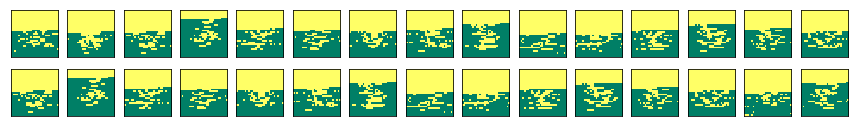

Press Enter to continue  
 Epoch #1, site #783 / 784           NLL=30.119, LowerBound=2.996
  generating samples...

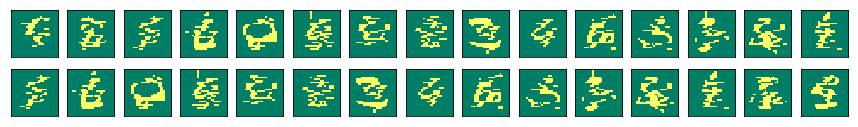

Press Enter to continue  
 Epoch #2, site #783 / 784           NLL=15.110, LowerBound=2.996
  generating samples...

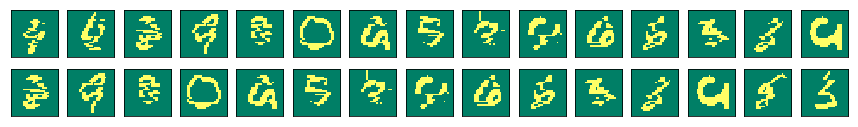

In [ ]:
learning_rate=0.08
for epoch in range(30):
    # one sweep, from right to left, then from left to right
    going_right=False
    for site in [i for i in range(n-1,0,-1)]+[i for i in range(n-1)]:
        # to update tensors[site] which is a 3-way tensor of size [dl,2,dr]
        sys.stdout.write("\r Epoch #%d, site #%d / %d           "%(epoch, site+1,n)); sys.stdout.flush()
        if(site==0): going_right=True
        gradients = torch.zeros_like(tensors[site])
        for i in [0,1]: # the pixel could be either 0 or 1
            idx=(data[:,site]==i).nonzero().type(torch.LongTensor).squeeze() # this returns indices of non-zero elements
            if(idx.numel()==0): continue
            left_vec = cache[site][idx,:,:] # a vector on the left of the site
            right_vec = cache[site+1][idx,:,:] # a vector on the right of the site
            A=tensors[site][:,data[idx,site],:]
            if(idx.numel()==1): 
                A=A.view(A.shape[0],1,A.shape[1])
                left_vec=left_vec.view(1,left_vec.shape[0],left_vec.shape[1])
                right_vec=right_vec.view(1,right_vec.shape[0],right_vec.shape[1])
            psi = left_vec @ A.permute(1,0,2) @right_vec # probability amplitude
            gradients[:,i,:] = torch.sum(left_vec.permute(0,2,1) @ right_vec.permute(0,2,1) / psi,0) 
        gradients = 2.0*(gradients/m-tensors[site])  
        tensors[site] += learning_rate * gradients/gradients.norm()
        orthogonalize(site,going_right)
        if(going_right):
            cache[site+1] = cache[site] @ tensors[site][:,data[:,site],:].permute(1,0,2)
            cache[site+1] /= cache[site+1].abs().max()
        else:
            cache[site] = tensors[site][:,data[:,site],:].permute(1,0,2) @ cache[site+1]
            cache[site] /= cache[site].abs().max()
    psi=get_psi()
    tensors_bak=tensors.copy()
    sys.stdout.write("NLL=%.3f, LowerBound=%.3f\n"%(-torch.mean(torch.log(psi*psi)),math.log(m)))
    sys.stdout.write("  generating samples...")
    imgs=gen_samples(30)
    show_imgs(imgs,2,15,15,2)
    tensors=tensors_bak.copy()
    input("Press Enter to continue  ")
